<a href="https://colab.research.google.com/github/ozgetokmak/deep-learning/blob/master/tubitak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#görüntü indirme

!gdown --id 1vtBqgWnQz5r7q_FIel6GbSsawx6sQwyW

Downloading...
From: https://drive.google.com/uc?id=1vtBqgWnQz5r7q_FIel6GbSsawx6sQwyW
To: /content/besbin.zip
86.0MB [00:03, 27.5MB/s]


In [ ]:
!unzip /content/besbin.zip

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

 
#Görüntü modülü, görüntü nesnesini önişlemek için içe aktarılır
#preprocess_input modülü, piksel değerlerini VGG16 modeli için uygun şekilde ölçeklendirmek için içe aktarılır.

Using TensorFlow backend.


In [ ]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

#include_top --> final dense layerı isteyip istemediğimizi sorar.
#Burada ilk önce VGG16 modelini tensorflow keras'tan içe aktarıyoruz.

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

553467904/553467096 [==============================] - 27s 0us/step


**VGG-16, girişinde sabit boyutlu (224 x 224 x 3) bir RGB görüntü alacak ve ardından bunu bir dizi alternatif evrişimli ve maksimum havuzlama katmanından geçirecek ve ardından tamamen bağlı üç katmanla kapatılacak şekilde ayarlanmıştır. 4096, 4096 ve 1000 nöron, burada son katman softmax sınıflandırma katmanımızdır. 

**Her katmanda çıktıda ilk boyut 'None' bunun anlamı None = x olsun, sonuçta x kadar çıktı verir.






In [ ]:
import numpy as np #dizi işleme işlemi için
import matplotlib.pyplot as plt

def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [ ]:
#özellik çıkarıcı
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)


#modeli son katmanı(sınıflandırma katmanını f2c dense) kaldırarak kopyalamak-- görüntüyü yüksek doğrulukta sınıflandırabilmek için 

Beklentimiz, fc2 aktivasyonlarının görüntünün çok iyi bir temsilini oluşturmasıdır, öyle ki benzer görüntüler benzer aktivasyonlar üretmelidir. Yani benzer içeriğe sahip iki görüntünün fc2 aktivasyonları birbirine çok yakın olmalıdır. 

In [ ]:
images_path = '/content/besbin'
image_extensions = ['.jpg', '.png', '.jpeg', '.tif']   
max_num_images = 10000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 4953 images to analyze


In [ ]:
import time
tic = time.clock()


features = []
for i, image_path in enumerate(images):
    if i % 1000 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

#her görüntüyü açan, özellik vektörünü çıkaran ve her görüntü için aktivasyonları içeren bir liste döngüsü, her 100 görüntüde bildirim alıyoruz.

analyzing image 0 / 4953. Time: 0.0008 seconds.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  # This is added back by InteractiveShellApp.init_path()


analyzing image 1000 / 4953. Time: 13.2645 seconds.
analyzing image 2000 / 4953. Time: 11.4194 seconds.
analyzing image 3000 / 4953. Time: 11.5089 seconds.
analyzing image 4000 / 4953. Time: 11.4674 seconds.
finished extracting features for 4953 images


In [ ]:
#ilk 300 nesneyi tutacak bir PCA döngüsü başlatmak için
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

#temel bileşen analizi(PCA) koduyla 4096 bitlik özellik vektörünün içindeki fazlalığıyla meydana gelebilecek aşırı benzerliği elemine etmek ve alan/bellek gereksinimlerini en aza indirgemek
#PCA redündansı azaltır, hesaplamayı hızlandırır, kapladığı bellek miktarını azaltır. 

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
pca_features = pca.transform(features)

#uzunluğu 4096 olan PCA tarafından bulunan 300 boyutlu bir indirgenmiş özellik vektörüne dönüştürebiliriz.


reverse image query yapmak için gerekli PCA matrisi yazıldı. 
PCA matrisi her görüntü için üst düzey özellik algılamalarına sahip 300 elemanlı bir satır içerir.


In [ ]:
#random bir sorgu görüntüsü alalım
import random

# random bir sorgu görüntüsü alma
x=random.random()

query_image_idx = int(len(images) * x)


# gösterme
img = image.load_img(images[query_image_idx-1])
plt.imshow(img)
plt.title(images[query_image_idx-1].split("/")[3])

Benzer içeriğe sahip iki görüntünün benzer özellik vektörleri üretmesi gerekir. Rastgele bir görüntü seçilir ardından bu görüntünün PCA özellik vektörüne mesafesini cos yöntemiyle bulur.

In [ ]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [ ]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

#sorgu görüntüsüne en çok benzeyen görüntü, mesafe hesaplamasına dahil edildiğinden, önemsiz bir şekilde sorgu görüntüsünün kendisi olacaktır bu yüzden onu atlayıp [1:6] çalıştırdık.

In [ ]:
# her bir benzerlik sonucunu 100 piksel yüksekliğinde yükleme
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# görüntüleri tek bir görüntüde birleştirme 
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# resmi gösterme
plt.figure(figsize = (16,12))
plt.imshow(concat_image)
    

In [ ]:
#cos mesafesini hesaplayacak fonksiyon

def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    names=[]
    for idx in indexes:
        img = image.load_img(images[idx])
        name=images[idx].split("/")[3]
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
        names.append(name)
        

    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image,names

Text(0.5, 1.0, "['B_25600_6912.jpg', 'B_28672_9728.jpg', 'B_28672_10496.jpg', 'B_27392_7680.jpg', 'B_28160_8960.jpg']")

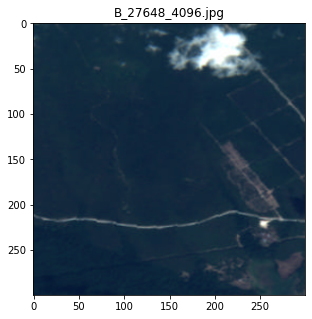

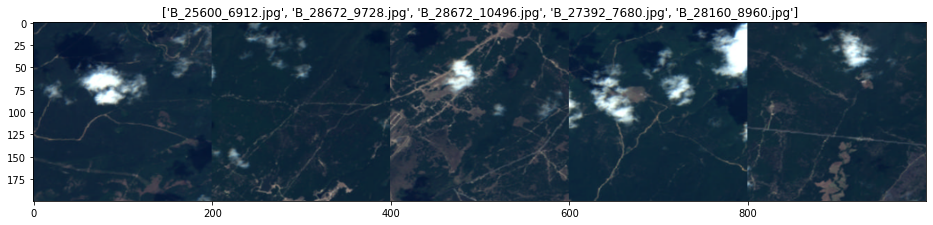

In [ ]:
# rastgele bir görüntü üzerinde sorgu yapar
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image,name = get_concatenated_images([query_image_idx], 300)
results_image,name = get_concatenated_images(idx_closest, 200)

plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title(images[query_image_idx].split("/")[3])

# sonuç görüntüleri gösterir
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title(name)